<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/surface_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install -q rioxarray
import geemap
import ee
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import rioxarray

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 923.1 kB/s eta 0:00:00


## Utility Functions

- Create a standard function to apply filters on image collection

In [2]:
def filterImageCollection(
        image_collection_id: str,
        geometry: ee.geometry.Geometry,
        date_range: tuple[str]
    ) -> ee.imagecollection.ImageCollection:

    imageCollection = ee.ImageCollection(image_collection_id)
    d1,d2 = date_range
    filtered = imageCollection.filter(
        ee.Filter.date(d1, d2) ## Filter by date
    ).filter(
        ee.Filter.bounds(geometry) ## Filter by bounds
    )

    return filtered

def kelvin_to_celsius(image):
    temp = image.multiply(0.02).subtract(273.15).rename('temp_C')
    return image.addBands(temp).copyProperties(image, ['system:time_start'])

In [3]:
## get the current dates
today = datetime.now()
d1 = today - timedelta(days=30)
current_date_range = (d1.date().strftime('%Y-%m-%d'), today.date().strftime('%Y-%m-%d'))
current_date_range

('2024-03-24', '2024-04-23')

## Visualizing satellite RGB image

In [4]:
admin = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
delhi = admin.filter(ee.Filter.eq('ADM1_NAME', 'Delhi'))\
.filter(ee.Filter.eq('ADM2_NAME', 'Delhi'))

geometry = delhi.geometry()

filtered_imgs = filterImageCollection(
    image_collection_id = 'COPERNICUS/S2_SR_HARMONIZED',
    geometry = geometry,
    date_range = current_date_range
)

In [5]:
image = filtered_imgs.median()
clipped_img = image.clip(geometry)

center = (28.6182,77.2009)
Map = geemap.Map(center=center, zoom=10)
boundary_viz_params = {
    'color':'red',
    "width":2,
    "lineType":"solid",
    'fillColorOpacity': 0.1
}
Map.addLayer(ee_object=delhi, vis_params=boundary_viz_params, name='Delhi Boundary')
viz_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', "B3", "B2"]
}
Map.addLayer(clipped_img, viz_params, name='Sentinel')
Map

Map(center=[28.6182, 77.2009], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Visualizing the surface temperature data

In [6]:
## Filtered_image_Collection
surface_temp = filterImageCollection(
        image_collection_id = "MODIS/061/MOD11A1",
        geometry = geometry,
        date_range = current_date_range
    )\
    .select('LST_Day_1km')\
    .map(kelvin_to_celsius)

surface_temp.size()

## Calculate the median composite for plotting

In [7]:
temp_mean = surface_temp.median().clip(geometry)
temp_mean.bandNames()

In [8]:
center = (28.6182,77.2009)
Map = geemap.Map(center=center, zoom=10)
viz_params = {
    'min': 0,
    'max': 50,
    'bands': ['temp_C'],
    'palette': ['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
}
Map.addLayer(temp_mean, viz_params, name='Surface Temperature')
Map

Map(center=[28.6182, 77.2009], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Extract the time series data

In [16]:
def summarizeRegion(image, geometry, bandName):
    '''
    Compute the average regional stat of a given image
    and store it in image property metadata
    '''
    stat = ee.Number(image.reduceRegion(
        reducer = ee.Reducer.mean(),
        geometry = geometry,
        scale = 1000, ## scale = 10 m pixel, gee will down/up sample the image as required
        maxPixels = 1e10
    ).get(bandName))

    return image.set('average_stat', stat)


# Get a list of dictionaries containing image information

def extract_time_series(image_collection, stat='average_stat', time_prop_id = 'system:time_start'):
    '''
    Extract timeseries values, the average values and the time
    here time will be converted to python datetime object
    It will set as none where average value is not found
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    x, y = [], []
    for prop in tqdm(properties, unit=" data"):
        try:
            stat = prop['average_stat']
            time = prop[time_prop_id]/1000 ## timestamps in seconds
            time = datetime.fromtimestamp(time) #.strftime('%Y-%m-%d')

            y.append(stat)
            x.append(time)

        except Exception as e:
            ## Skip the reading if null value found
            pass

    return x,y

def plot_time_series(x,y, title='Average Surface Temperature'):
    '''
    Plot the time series given the x - datetime, y- stat
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(x,y)
    ax.set_xlabel("Date")
    ax.set_ylabel(title)
    ax.set_title(title)
    return fig

In [14]:
## First see calculating the mean of the temperature over the region
stat = summarizeRegion(temp_mean, geometry, 'temp_C')
average_temperature = stat.getInfo()['properties']['average_stat']
average_temperature

33.13953101924447

In [17]:
## Extract the average temperature for each image over the region
time_series_data = surface_temp.map(lambda x: summarizeRegion(x, geometry, 'temp_C'))
x,y = extract_time_series(time_series_data)

  0%|          | 0/23 [00:00<?, ? data/s]

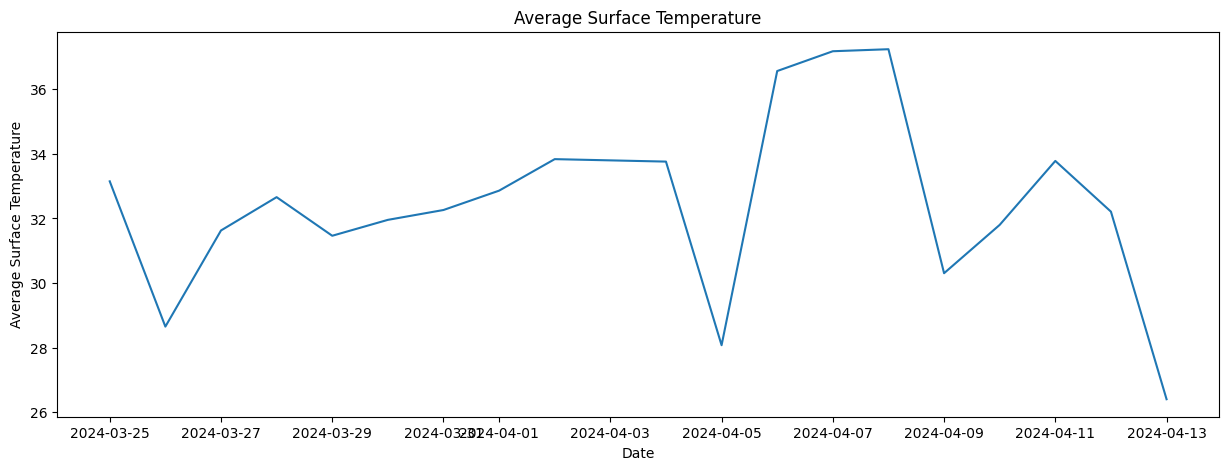

In [19]:
fig = plot_time_series(x,y)
fig.show()

## Export the data

Export the surface temperature raster image:

In [20]:
temp_mean.bandNames()

In [59]:
geemap.ee_export_image(
    temp_mean.clip(geometry),
    filename='surface_temperature.tif',
    scale=1000,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/surface_temperature.tif


In [22]:
import pandas as pd

df = pd.DataFrame({"datetime":x, "avg_surf_temp":y})
df.head()

,datetime,avg_surf_temp
0,2024-03-25,33.150594
1,2024-03-26,28.651406
2,2024-03-27,31.628886
3,2024-03-28,32.660712
4,2024-03-29,31.465001


In [23]:
df.to_parquet('average_surface_temperature.parquet')

## Converting the raster to xyz point data


In [60]:
xds = rioxarray.open_rasterio('surface_temperature.tif')\
        .sel(band=1)\
        .to_pandas()

xds = (xds*0.02-276).stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: 'temp'})
print(xds.shape)
xds.head()

(3132, 3)


,lat,lng,temp
0,28.885328,76.828415,30.04
1,28.885328,76.837398,30.02
2,28.885328,76.846381,30.00
3,28.885328,76.855364,29.64
4,28.885328,76.864347,28.95


In [61]:
xds['temp'].describe()

count    3132.000000
mean       30.237490
std         1.776846
min        25.180000
25%        29.050000
50%        30.235000
75%        31.330000
max        35.780000
Name: temp, dtype: float64

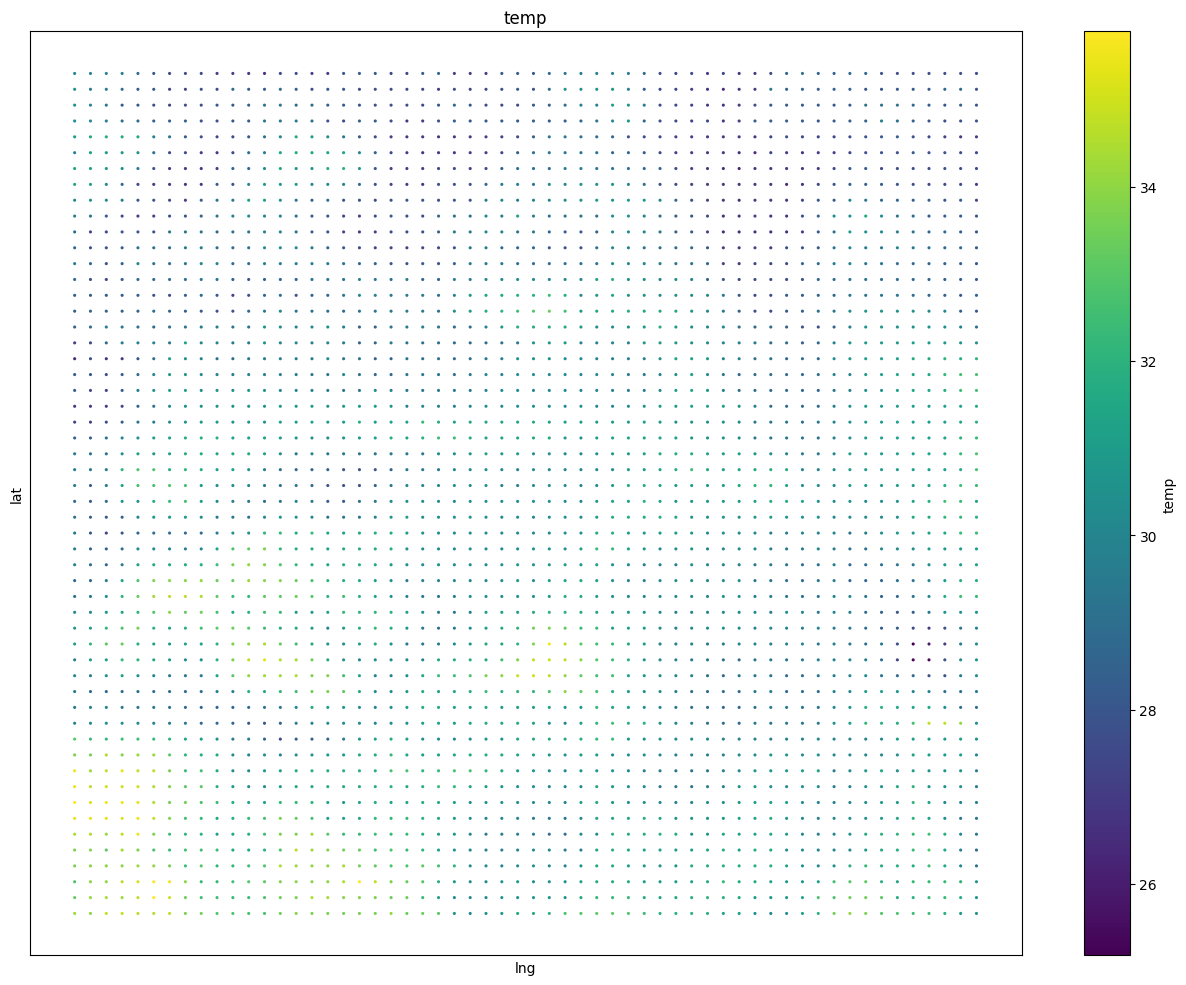

In [62]:
#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

plot_scatter(xds,metric_col='temp')

## Converting to H3 spatial index



In [63]:
!pip install -q h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.2 MB/s eta 0:00:00


In [64]:
import h3

In [76]:
APERTURE_SIZE = 8
hex_col = 'hex'+str(APERTURE_SIZE)

In [77]:
# find hexs containing the points
xds[hex_col] = xds.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

In [78]:
xds.sample(5)

,lat,lng,temp,hex9,hex8
2867,28.445153,77.052993,29.98,893da11aa83ffff,883da11aa9fffff
842,28.759564,77.097909,32.43,893da18e853ffff,883da18e85fffff
2904,28.436170,76.864347,34.20,893da1c506fffff,883da1c507fffff
291,28.840412,76.837398,31.24,893da191b83ffff,883da191b9fffff
2717,28.472103,77.268589,30.21,893da100847ffff,883da10085fffff


In [79]:
# calculate elevation average per hex
df_temp = xds.groupby(hex_col)['temp'].mean().to_frame('temp').reset_index()
df_temp.sample(5)

,hex8,temp
2017,883da18db9fffff,30.30
935,883da1170bfffff,30.80
1696,883da18925fffff,32.00
2489,883da1b949fffff,30.09
1220,883da18129fffff,31.35


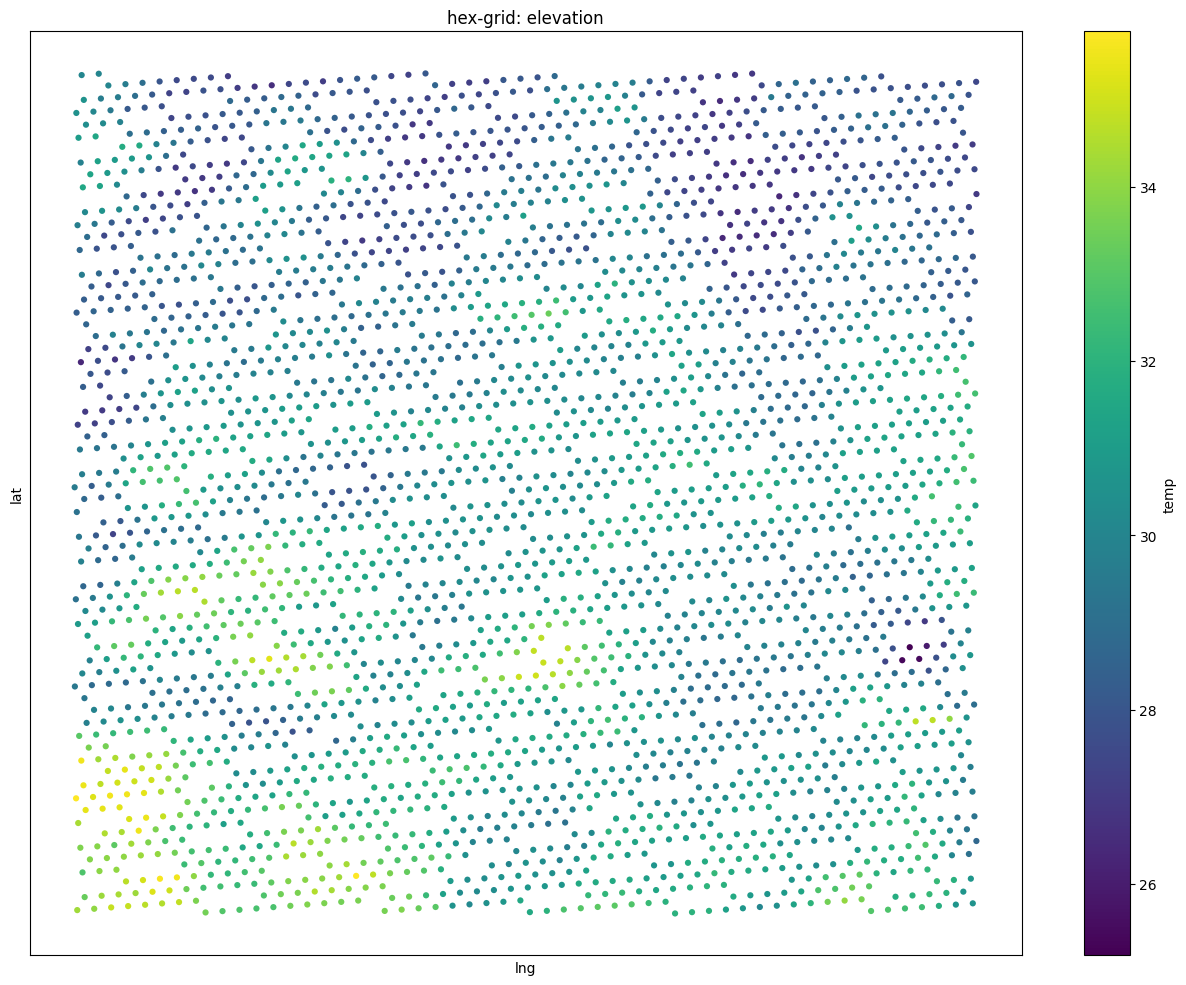

In [80]:
#find center of hex for visualization
df_temp['lat'] = df_temp[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_temp['lng'] = df_temp[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# plot the hexes
plot_scatter(df_temp, metric_col='temp', marker='o')
plt.title('hex-grid: elevation');